In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv("/content/Customers.csv")
products = pd.read_csv("/content/Products.csv")
transactions = pd.read_csv("/content/Transactions.csv")

# Display basic information
print("Customers Data:")
print(customers.head())
print("\nProducts Data:")
print(products.head())
print("\nTransactions Data:")
print(transactions.head())


Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Data:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127 

In [6]:
# Check for missing values
print("\nMissing values in Customers:")
print(customers.isnull().sum())

print("\nMissing values in Products:")
print(products.isnull().sum())

print("\nMissing values in Transactions:")
print(transactions.isnull().sum())

# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Check for duplicates
print("\nDuplicates in Customers:", customers.duplicated().sum())
print("Duplicates in Products:", products.duplicated().sum())
print("Duplicates in Transactions:", transactions.duplicated().sum())



Missing values in Customers:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Missing values in Products:
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Missing values in Transactions:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

Duplicates in Customers: 0
Duplicates in Products: 0
Duplicates in Transactions: 0


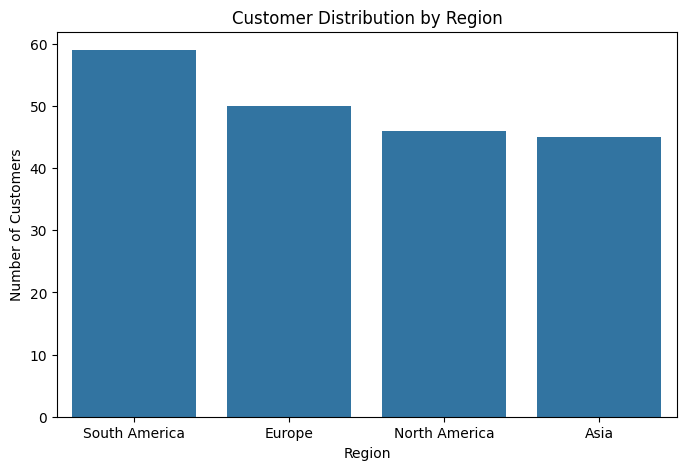

In [7]:
# Region distribution
region_counts = customers['Region'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.title("Customer Distribution by Region")
plt.ylabel("Number of Customers")
plt.xlabel("Region")
plt.show()


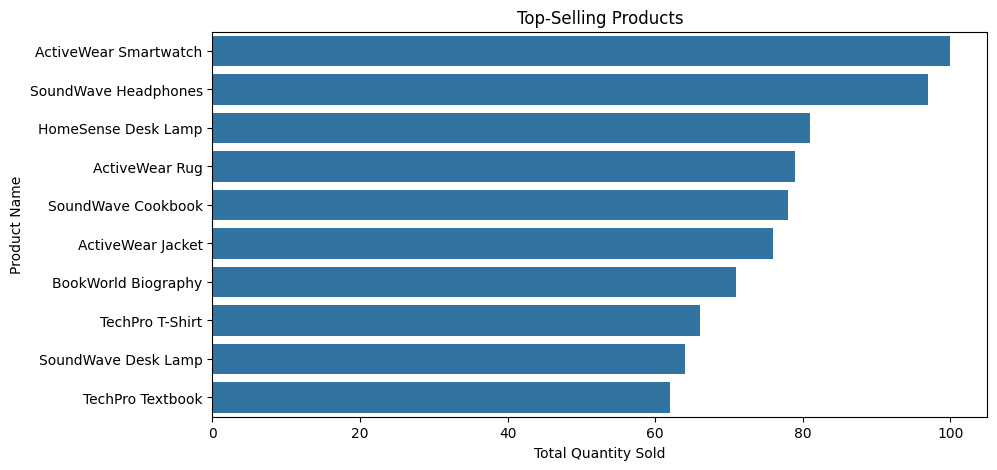

In [8]:
# Merge transactions with products
merged_data = transactions.merge(products, on="ProductID")
top_products = merged_data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top-Selling Products")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Name")
plt.show()


In [10]:
# Aggregate customer-level data
customer_data = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).rename(columns={'TotalValue': 'TotalSpend', 'Quantity': 'TotalQuantity'}).reset_index()

# Merge with customers
customer_profile = customers.merge(customer_data, on="CustomerID", how="left").fillna(0)
print(customer_profile.head())

  CustomerID        CustomerName         Region SignupDate  TotalSpend  \
0      C0001    Lawrence Carroll  South America 2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia 2022-02-13     1862.74   
2      C0003      Michael Rivera  South America 2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America 2022-10-09     5354.88   
4      C0005         Laura Weber           Asia 2022-08-15     2034.24   

   TotalQuantity  
0           12.0  
1           10.0  
2           14.0  
3           23.0  
4            7.0  


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Normalize data
features = customer_profile[['TotalSpend', 'TotalQuantity']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Compute similarity
similarity_matrix = cosine_similarity(scaled_features)

# Create lookalike recommendations
lookalikes = {}
for idx, customer in enumerate(customer_profile['CustomerID']):
    scores = list(enumerate(similarity_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:4]  # Top 3 lookalikes
    lookalikes[customer] = [(customer_profile.iloc[i[0]]['CustomerID'], round(i[1], 2)) for i in scores]

# Save to CSV
lookalikes_df = pd.DataFrame.from_dict(
    {k: [v[0][0], v[0][1], v[1][0], v[1][1], v[2][0], v[2][1]] for k, v in lookalikes.items()},
    orient='index',
    columns=['Lookalike1', 'Score1', 'Lookalike2', 'Score2', 'Lookalike3', 'Score3']
)
lookalikes_df.to_csv('Lookalike.csv', index_label='CustomerID')


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_features)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_profile['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.7102764046737506


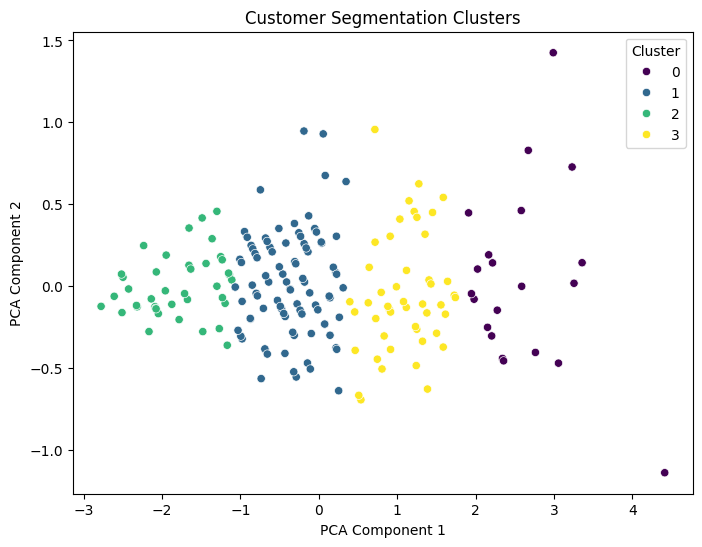

In [13]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=customer_profile['Cluster'], palette='viridis')
plt.title("Customer Segmentation Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
